In [1]:
# -------------------------------------
# --- Go to correct starting folder ---
# -------------------------------------
# (when running jupyter lab in the browser, the notebook starts with CWD = folder where it is located, which breaks imports, ...)
import os
import pathlib

while not ((cwd := pathlib.Path(os.getcwd())) / "requirements.txt").exists():
    os.chdir(cwd.parent)  # go 1 folder up

In [2]:
# other imports
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt

from core.data import SearchResult
from core.search import semantic_search, textual_search
from notebooks.colors import CLR_BLACK, CLR_BLUE, CLR_DARK_GREEN, CLR_GREEN, CLR_GREY
from notebooks.helpers import enable_metadata, get_data_folder, get_figures_folder, get_images_folder

/Users/bertpluymers/miniconda3/envs/image-search-llm/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# 1. Introduction

In this notebook we will analyze what is a good threshold value (min_score-value) to be used in our semantic search command.

We perform a precision-recall analysis for different threshold values (from -1.00 to 1.00 in steps of 0.01) and see where we see the best trade-off between precision and recall.  To do this, we look at the F1-score and see where it is maximized.

We will perform computations as follows:
- for each embedding size:
  - for each (query, threshold), we compute recall, precision & F1-score
  - for each threshold, we compute the _average_ recall, precision & F1-score over all queries
  - best threshold for this embedding size is the one with the highest average F1-score

In [3]:
# queries we will test
queries = ["dog", "coffee", "food", "sheep", "rabbit", "snow", "bike"]
ground_truth: dict[str, list[str]] = dict()  # ground truth results (file names) for each query

for query in queries:
    ground_truth_path = get_data_folder() / "semantic_search" / "ground_truth" / query
    ground_truth[query] = [str(file.name) for file in ground_truth_path.glob("*.jpg")]

print("GROUND TRUTH")
for query, results in ground_truth.items():
    print(f"   {query.ljust(10)} -> {len(results)} results")

GROUND TRUTH
   dog        -> 2 results
   coffee     -> 9 results
   food       -> 36 results
   sheep      -> 9 results
   rabbit     -> 2 results
   snow       -> 15 results
   bike       -> 12 results


In [4]:
# prepare main loop
emb_sizes = [128, 512, 2048, 0]  # 0 = textual search
min_scores = list(np.arange(-1.00, 1.01, 0.01))  # threshold values to sweep

avg_recalls_by_emb_size: dict[int, list[float]] = defaultdict(list)  # dict mapping emb_size -> list of RECALL values
avg_precisions_by_emb_size: dict[int, list[float]] = defaultdict(
    list
)  # dict mapping emb_size -> list of PRECISION values
avg_f1_scores_by_emb_size: dict[int, list[float]] = defaultdict(
    list
)  # dict mapping emb_size -> list of F1_SCORE values

# main loop
for emb_size in emb_sizes:
    # enable metadata for this size
    if emb_size > 0:
        # emb_size==0 represents textual search, so we don't need to enable different
        enable_metadata(emb_size)

    # all results by query
    if emb_size == 0:
        # textual search
        results_by_query: dict[str, list[SearchResult]] = {
            query: textual_search(
                directory=get_images_folder(),
                query=query,
                use_time_location_data=True,
            )
            for query in queries
        }
    else:
        # semantic search
        results_by_query: dict[str, list[SearchResult]] = {
            query: semantic_search(
                directory=get_images_folder(),
                query=query,
                min_score=-1000,  # set a very low threshold to get all results; since we use cosine similarity, all scores will always be >=-1.0
            )
            for query in queries
        }

    # all_files
    all_files = {result.filename for query, results in results_by_query.items() for result in results}

    # threshold sweep
    for min_score in min_scores:
        # init per-query results
        recall_by_query = []
        precision_by_query = []
        f1_score_by_query = []

        # go over each query and compute recall & precision
        for query in queries:
            # results for this query and threshold
            result = [result.filename for result in results_by_query[query] if result.score >= min_score]

            # compute TP, FP, TN, FN
            tp_count = len([file for file in result if file in ground_truth[query]])
            fp_count = len([file for file in result if file not in ground_truth[query]])
            fn_count = len([file for file in ground_truth[query] if file not in result])
            tn_count = len([file for file in all_files if file not in ground_truth[query] and file not in result])

            recall_value = tp_count / (tp_count + fn_count)
            precision_value = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 1.0
            f1_score_value = (
                2 * precision_value * recall_value / (precision_value + recall_value)
                if (precision_value + recall_value) > 0
                else 0
            )

            recall_by_query.append(recall_value)
            precision_by_query.append(precision_value)
            f1_score_by_query.append(f1_score_value)

        # compute avg recall and precision for this threshold
        avg_recall = float(np.mean(recall_by_query))
        avg_precision = float(np.mean(precision_by_query))
        avg_f1 = float(np.mean(f1_score_by_query))

        # append to lists
        avg_recalls_by_emb_size[emb_size].append(avg_recall)
        avg_precisions_by_emb_size[emb_size].append(avg_precision)
        avg_f1_scores_by_emb_size[emb_size].append(avg_f1)

    # --- print results -----------------------------------
    print("-" * 50)
    print(f" Results for embedding size {emb_size}:")
    print("-" * 50)
    print(f"  min_score  ->     recall   precision          F1")
    for min_score, recall, precision, f1 in zip(
        min_scores,
        avg_recalls_by_emb_size[emb_size],
        avg_precisions_by_emb_size[emb_size],
        avg_f1_scores_by_emb_size[emb_size],
    ):
        if f1 == max(avg_f1_scores_by_emb_size[emb_size]):
            indicator = "<---"
        else:
            indicator = ""
        print(f"     {min_score:6.2f}  -> {recall:10.4f}  {precision:10.4f}  {f1:10.4f}    {indicator}")

    print()

--------------------------------------------------
 Results for embedding size 128:
--------------------------------------------------
  min_score  ->     recall   precision          F1
      -1.00  ->     1.0000      0.0810      0.1423    
      -0.99  ->     1.0000      0.0810      0.1423    
      -0.98  ->     1.0000      0.0810      0.1423    
      -0.97  ->     1.0000      0.0810      0.1423    
      -0.96  ->     1.0000      0.0810      0.1423    
      -0.95  ->     1.0000      0.0810      0.1423    
      -0.94  ->     1.0000      0.0810      0.1423    
      -0.93  ->     1.0000      0.0810      0.1423    
      -0.92  ->     1.0000      0.0810      0.1423    
      -0.91  ->     1.0000      0.0810      0.1423    
      -0.90  ->     1.0000      0.0810      0.1423    
      -0.89  ->     1.0000      0.0810      0.1423    
      -0.88  ->     1.0000      0.0810      0.1423    
      -0.87  ->     1.0000      0.0810      0.1423    
      -0.86  ->     1.0000      0.0810      

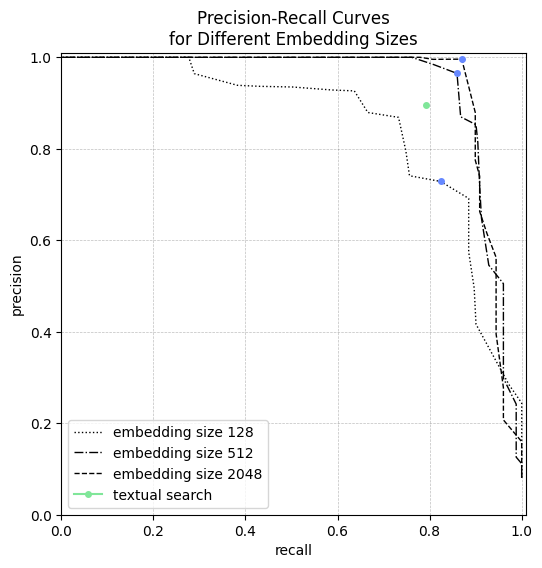

In [5]:
# --- precision-recall plot -------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

line_styles = {
    128: ":",
    512: "-.",
    2048: "--",
}

for emb_size in emb_sizes:
    if emb_size > 0:
        # prep data for this embedding size
        precision = avg_precisions_by_emb_size[emb_size]
        recall = avg_recalls_by_emb_size[emb_size]
        f1 = avg_f1_scores_by_emb_size[emb_size]
        i_max = f1.index(max(f1))  # index of max F1 score

        ax.plot(
            recall,
            precision,
            label=f"embedding size {emb_size}",
            linestyle=line_styles[emb_size],
            color=CLR_BLACK,
            linewidth=1,
        )

        ax.plot(
            recall[i_max],
            precision[i_max],
            marker="o",
            markersize=4,
            color=CLR_BLUE,
            markeredgecolor=CLR_BLUE,
        )

ax.plot(
    avg_recalls_by_emb_size[0][0],
    avg_precisions_by_emb_size[0][0],
    marker="o",
    markersize=4,
    color=CLR_GREEN,
    markeredgecolor=CLR_GREEN,
    label="textual search",
)

ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.legend(loc="lower left")
ax.grid(ls="--", color=CLR_BLACK, lw=0.5, alpha=0.25)


ax.set_title("Precision-Recall Curves\nfor Different Embedding Sizes")

# --- save --------------------------------------
fig_file = get_figures_folder() / "semantic_search_precision_recall.png"
fig.savefig(fig_file, dpi=600)

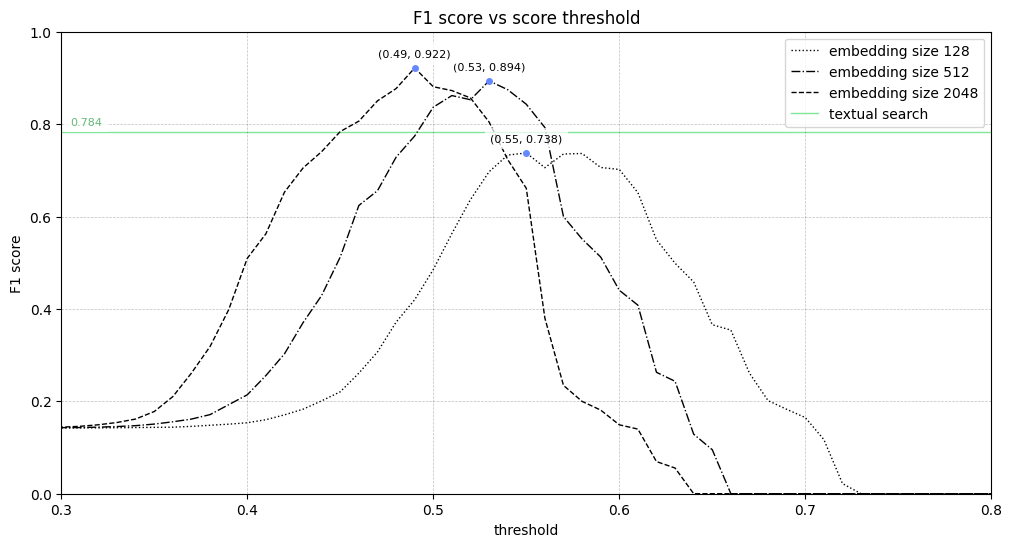

In [6]:
# --- precision-recall plot -------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

line_styles = {
    128: ":",
    512: "-.",
    2048: "--",
}

for emb_size in emb_sizes:
    if emb_size > 0:
        # prep data for this embedding size
        f1 = avg_f1_scores_by_emb_size[emb_size]
        i_max = f1.index(max(f1))  # index of max F1 score

        ax.plot(
            min_scores,
            f1,
            label=f"embedding size {emb_size}",
            linestyle=line_styles[emb_size],
            color=CLR_BLACK,
            linewidth=1,
        )

        ax.plot(
            min_scores[i_max],
            f1[i_max],
            marker="o",
            markersize=4,
            color=CLR_BLUE,
            markeredgecolor=CLR_BLUE,
        )

        ax.text(
            min_scores[i_max],
            f1[i_max] + 0.02,
            f"({min_scores[i_max]:.2f}, {f1[i_max]:.3f})",
            ha="center",
            va="bottom",
            fontsize=8,
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"),
        )

ax.plot(
    [-1, 1],
    [avg_f1_scores_by_emb_size[0][0]] * 2,
    linestyle="-",
    color=CLR_GREEN,
    linewidth=1,
    zorder=-1,
    label="textual search",
)

ax.text(
    0.305,
    avg_f1_scores_by_emb_size[0][0] + 0.01,
    f"{avg_f1_scores_by_emb_size[0][0]:.3f}",
    ha="left",
    va="bottom",
    fontsize=8,
    color=CLR_DARK_GREEN,
    bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"),
)


ax.set_xlim(0.3, 0.8)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("threshold")
ax.set_ylabel("F1 score")
ax.legend(loc="upper right")
ax.grid(ls="--", color=CLR_BLACK, lw=0.5, alpha=0.25)

ax.set_title("F1 score vs score threshold")

# --- save --------------------------------------
fig_file = get_figures_folder() / "semantic_search_f1_curve.png"
fig.savefig(fig_file, dpi=600)